In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

from cleverhans.attacks import FastGradientMethod, SaliencyMapMethod
from cleverhans.utils_tf import model_train , model_eval , batch_eval, model_argmax
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.utils import other_classes
from cleverhans.utils_keras import KerasModelWrapper

import tensorflow as tf
from tensorflow.python.platform import flags

from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('bmh')

K.set_learning_phase(1)

FLAGS = flags.FLAGS

flags.DEFINE_integer('nb_epochs', 50, 'Number of epochs to train model')
flags.DEFINE_integer('batch_size', 64, 'Size of training batches')
flags.DEFINE_integer('learning_rate', 0.005, 'Learning rate for training')
flags.DEFINE_integer('nb_classes', 2, 'Number of classification classes')
flags.DEFINE_integer('source_samples', 10, 'Nb of test set examples to attack')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
print()
print()
print("================================= Start of preprocessing stage ==============================")

names = ['duration', 'protocol', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'other']

df_train = pd.read_csv('./NSL_KDD/KDDTrain+.txt', names=names, header=None)
df_test = pd.read_csv('./NSL_KDD/KDDTest+.txt', names=names, header=None)
print("Initial training and test data shapes: ", df_train.shape, df_test.shape)

full = pd.concat([df_train, df_test])
assert full.shape[0] == df_train.shape[0] + df_test.shape[0]

full['label'] = full['attack_type']

# DoS Attacks
full.loc[full.label == 'neptune', 'label'] = 'other'
full.loc[full.label == 'back', 'label'] = 'other'
full.loc[full.label == 'land', 'label'] = 'other'
full.loc[full.label == 'pod', 'label'] = 'other'
full.loc[full.label == 'smurf', 'label'] = 'other'
full.loc[full.label == 'teardrop', 'label'] = 'other'
full.loc[full.label == 'mailbomb', 'label'] = 'other'
full.loc[full.label == 'processtable', 'label'] = 'other'
full.loc[full.label == 'udpstorm', 'label'] = 'other'
full.loc[full.label == 'apache2', 'label'] = 'other'
full.loc[full.label == 'worm', 'label'] = 'other'

# User-to-root (U2R)
full.loc[full.label == 'buffer_overflow', 'label'] = 'other'
full.loc[full.label == 'loadmodule', 'label'] = 'other'
full.loc[full.label == 'perl', 'label'] = 'other'
full.loc[full.label == 'rootkit', 'label'] = 'other'
full.loc[full.label == 'sqlattack', 'label'] = 'other'
full.loc[full.label == 'xterm', 'label'] = 'other'
full.loc[full.label == 'ps', 'label'] = 'other'

# Remote-to-local (R2L)
full.loc[full.label == 'ftp_write', 'label'] = 'other'
full.loc[full.label == 'guess_passwd', 'label'] = 'other'
full.loc[full.label == 'imap', 'label'] = 'other'
full.loc[full.label == 'multihop', 'label'] = 'other'
full.loc[full.label == 'phf', 'label'] = 'other'
full.loc[full.label == 'spy', 'label'] = 'other'
full.loc[full.label == 'warezclient', 'label'] = 'other'
full.loc[full.label == 'warezmaster', 'label'] = 'other'
full.loc[full.label == 'xlock', 'label'] = 'other'
full.loc[full.label == 'xsnoop', 'label'] = 'other'
full.loc[full.label == 'snmpgetattack', 'label'] = 'other'
full.loc[full.label == 'httptunnel', 'label'] = 'other'
full.loc[full.label == 'snmpguess', 'label'] = 'other'
full.loc[full.label == 'sendmail', 'label'] = 'other'
full.loc[full.label == 'named', 'label'] = 'other'

# Probe attacls
full.loc[full.label == 'satan', 'label'] = 'other'
full.loc[full.label == 'ipsweep', 'label'] = 'other'
full.loc[full.label == 'nmap', 'label'] = 'other'
full.loc[full.label == 'portsweep', 'label'] = 'other'
full.loc[full.label == 'saint', 'label'] = 'other'
full.loc[full.label == 'mscan', 'label'] = 'other'

full = full.drop(['other', 'attack_type'], axis=1)
print("Unique labels", full.label.unique())

# Generate One - Hot encoding
full2 = pd.get_dummies(full, drop_first=False)

# Separate training and test sets again
features = list(full2.columns[:-2])   # Due to One-Hot encoding
y_train = np.array(full2[0: df_train.shape[0]][['label_normal', 'label_other']])
X_train = full2[0: df_train.shape[0]][features]

y_test = np.array(full2[df_train.shape[0]: ][['label_normal', 'label_other']])
X_test = full2[df_train.shape[0]: ][features]

# Scale data
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = np.array(scaler.transform(X_train))
X_test_scaled = np.array(scaler.transform(X_test))

# Generate label encoding for Logistic regression
labels = full.label.unique()
le = LabelEncoder()
le.fit(labels)
y_full = le.transform(full.label)
y_train_l = y_full[0: df_train.shape[0]]
y_test_l = y_full[df_train.shape[0]: ]

print("Training dataset shape", X_train_scaled.shape, y_train.shape)
print("Test dataset shape", X_test_scaled.shape, y_test.shape)
print("Label encoder y shape", y_train_l.shape, y_test_l.shape)

print("================================= End of preprocessing stage ================================")
print()
print()

print("======================= Start of adversarial sample generation ==============================")
print()
print()

def mlp_model():
    """
    Generate a Multilayer Perceptron model
    """
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(FLAGS.nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    return model

def mlp_model2():
    """
    Generate a Multilayer Perceptron model
    """
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1], )))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(FLAGS.nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    return model

def evaluate():
    """
    Model evaluation function
    """
    eval_params = {'batch_size': FLAGS.batch_size}
    accuracy = model_eval(sess, x, y, predictions, X_test_scaled, y_test, args=eval_params)

    print("Test accuracy on legitimate test samples: " + str(accuracy))


# Tensorflow placeholder variables
x = tf.placeholder(tf.float32, shape=(None, X_train_scaled.shape[1]))
y = tf.placeholder(tf.float32, shape=(None, FLAGS.nb_classes))

tf.set_random_seed(42)
model = mlp_model2()
sess = tf.Session()
predictions = model(x)
init = tf.global_variables_initializer()
sess.run(init)

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')
# Train the model
train_params = {'nb_epochs': FLAGS.nb_epochs, 'batch_size': FLAGS.batch_size, 'learning_rate': FLAGS.learning_rate, 'verbose': 0}
train_params2 = {'epochs': FLAGS.nb_epochs, 'batch_size': FLAGS.batch_size, 'verbose': 1}
model.fit(X_train_scaled, y_train, callbacks=[earlystop, checkpointer, tensorboard], **train_params2)
model.evaluate(X_test_scaled, y_test)
# model_train(sess, x, y, predictions, X_train_scaled, y_train, evaluate=evaluate, callbacks=[earlystop, checkpointer, tensorboard], args=train_params)



================================= Start of preprocessing stage ==============================
Initial training and test data shapes:  (125973, 43) (22544, 43)
Unique labels ['normal' 'other']
Training dataset shape (125973, 122) (125973, 2)
Test dataset shape (22544, 122) (22544, 2)
Label encoder y shape (125973,) (22544,)
================================= End of preprocessing stage ================================


======================= Start of adversarial sample generation ==============================


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               31488     
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
___________________

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


125973/125973 [==============================] - 8s - loss: 0.0274 - acc: 0.9903     
Epoch 3/50
125973/125973 [==============================] - 8s - loss: 0.0212 - acc: 0.9922     
Epoch 4/50
125973/125973 [==============================] - 8s - loss: 0.0178 - acc: 0.9932     
Epoch 5/50
125973/125973 [==============================] - 8s - loss: 0.0174 - acc: 0.9937     
Epoch 6/50
125973/125973 [==============================] - 9s - loss: 0.0163 - acc: 0.9943     
Epoch 7/50
125973/125973 [==============================] - 8s - loss: 0.0153 - acc: 0.9945     
Epoch 8/50
125973/125973 [==============================] - 8s - loss: 0.0139 - acc: 0.9953     
Epoch 9/50
125973/125973 [==============================] - 8s - loss: 0.0141 - acc: 0.9951     
Epoch 10/50
125973/125973 [==============================] - 8s - loss: 0.0135 - acc: 0.9952     
Epoch 11/50
125973/125973 [==============================] - 8s - loss: 0.0130 - acc: 0.9954     
Epoch 12/50
125973/125973 [============

[2.2710206681707805, 0.8096167494677076]

In [8]:
# Generate adversarial samples for all test datapoints
source_samples = X_test_scaled.shape[0]
source_samples

22544

In [9]:
# Jacobian-based Saliency Map
results = np.zeros((FLAGS.nb_classes, source_samples), dtype='i')
perturbations = np.zeros((FLAGS.nb_classes, source_samples), dtype='f')
grads = jacobian_graph(predictions, x, FLAGS.nb_classes)

In [10]:
X_adv = np.zeros((source_samples, X_test_scaled.shape[1]))
X_adv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
models = KerasModelWrapper(model)
jsma = SaliencyMapMethod(models, sess=sess)
jsma_params = {'theta': 1, 'gamma': 0.1, 'clip_min': 0., 'clip_max': 1., 'y_target': None}

In [26]:
count = 0
for sample_ind in range(source_samples):
    sample = X_test_scaled[sample_ind: (sample_ind+1)]
    current_class = int(np.argmax(y_test[sample_ind]))
    X_adv[sample_ind] = sample
    if current_class == 0:
        print("Index: {}, Current Class: {}\n".format(sample_ind, current_class))
        continue
        
    print("Index: {}, Current Class: {}".format(sample_ind, current_class))
    one_hot_target = np.zeros((1, FLAGS.nb_classes), dtype=np.float32)
    print("Initial: ", one_hot_target)
    one_hot_target[0, 0] = 1
    print("New: ", one_hot_target)
    jsma_params['y_target'] = one_hot_target
    adv_x = jsma.generate_np(sample, **jsma_params)
    
    # Check for success
#     new_val = model_argmax(sess, x, predictions, adv_x)
    new_val = np.argmax(model.predict(adv_x))
    print("New prediction: ", new_val) # Should be 0
    res = int(new_val == 0)
    
    # Compute number of modified features
    adv_x_reshape = adv_x.reshape(-1)
    test_in_reshape = X_test_scaled[sample_ind].reshape(-1)
    nb_changed = np.where(adv_x_reshape != test_in_reshape)[0].shape[0]
    percent_perturb = float(nb_changed)/adv_x.reshape(-1).shape[0]
    
    X_adv[sample_ind] = adv_x
    results[0, sample_ind] = res
    perturbations[0, sample_ind] = percent_perturb
    print()

Index: 0, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2, Current Class: 0

Index: 3, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5, Current Class: 0

Index: 6, Current Class: 0

Index: 7, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8, Current Class: 0

Index: 9, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11, Current Class: 0

Index: 12, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14, Current Class: 0

Index: 15, Current Class: 0

Index: 16, Current Class: 0

Index: 17, Current Cla

New prediction:  1

Index: 207, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 208, Current Class: 0

Index: 209, Current Class: 0

Index: 210, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 211, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 212, Current Class: 0

Index: 213, Current Class: 0

Index: 214, Current Class: 0

Index: 215, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 216, Current Class: 0

Index: 217, Current Class: 0

Index: 218, Current Class: 0

Index: 219, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 220, Current Class: 0

Index: 221, Current Class: 0

Index: 222, Current Class: 0

Index: 223, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 224, Current Class: 0

Index: 225, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 226, Current Class

New prediction:  0

Index: 377, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 378, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 379, Current Class: 0

Index: 380, Current Class: 0

Index: 381, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 382, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 383, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 384, Current Class: 0

Index: 385, Current Class: 0

Index: 386, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 387, Current Class: 0

Index: 388, Current Class: 0

Index: 389, Current Class: 0

Index: 390, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 391, Current Class: 0

Index: 392, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 393, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 

Index: 555, Current Class: 0

Index: 556, Current Class: 0

Index: 557, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 558, Current Class: 0

Index: 559, Current Class: 0

Index: 560, Current Class: 0

Index: 561, Current Class: 0

Index: 562, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 563, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 564, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 565, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 566, Current Class: 0

Index: 567, Current Class: 0

Index: 568, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 569, Current Class: 0

Index: 570, Current Class: 0

Index: 571, Current Class: 0

Index: 572, Current Class: 0

Index: 573, Current Class: 0

Index: 574, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 575, Cur

Index: 705, Current Class: 0

Index: 706, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 707, Current Class: 0

Index: 708, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 709, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 710, Current Class: 0

Index: 711, Current Class: 0

Index: 712, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 713, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 714, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 715, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 716, Current Class: 0

Index: 717, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 718, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 719, Current Class: 0

Index: 720, Current Class: 0

Index: 721, Current Class

New prediction:  1

Index: 892, Current Class: 0

Index: 893, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 894, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 895, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 896, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 897, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 898, Current Class: 0

Index: 899, Current Class: 0

Index: 900, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 901, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 902, Current Class: 0

Index: 903, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 904, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 905, Current Class: 0

Index: 906, Current Class: 0

Index: 907, Current Class: 1
Initia

New prediction:  1

Index: 1050, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1051, Current Class: 0

Index: 1052, Current Class: 0

Index: 1053, Current Class: 0

Index: 1054, Current Class: 0

Index: 1055, Current Class: 0

Index: 1056, Current Class: 0

Index: 1057, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1058, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1059, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1060, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1061, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1062, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1063, Current Class: 0

Index: 1064, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1065, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predi

New prediction:  1

Index: 1202, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1203, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1204, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1205, Current Class: 0

Index: 1206, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1207, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1208, Current Class: 0

Index: 1209, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1210, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1211, Current Class: 0

Index: 1212, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1213, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1214, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1215, Current Class:

New prediction:  0

Index: 1360, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1361, Current Class: 0

Index: 1362, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1363, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1364, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1365, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1366, Current Class: 0

Index: 1367, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1368, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1369, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1370, Current Class: 0

Index: 1371, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1372, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1373, Current Class:

New prediction:  0

Index: 1545, Current Class: 0

Index: 1546, Current Class: 0

Index: 1547, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1548, Current Class: 0

Index: 1549, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1550, Current Class: 0

Index: 1551, Current Class: 0

Index: 1552, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1553, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1554, Current Class: 0

Index: 1555, Current Class: 0

Index: 1556, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1557, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1558, Current Class: 0

Index: 1559, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1560, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1561, Current Class: 1
Initial:  [[0.

New prediction:  1

Index: 1726, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1727, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1728, Current Class: 0

Index: 1729, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1730, Current Class: 0

Index: 1731, Current Class: 0

Index: 1732, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1733, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1734, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1735, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1736, Current Class: 0

Index: 1737, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1738, Current Class: 0

Index: 1739, Current Class: 0

Index: 1740, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1741, Current

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1881, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1882, Current Class: 0

Index: 1883, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1884, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1885, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1886, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1887, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1888, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 1889, Current Class: 0

Index: 1890, Current Class: 0

Index: 1891, Current Class: 0

Index: 1892, Current Class: 0

Index: 1893, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1894, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 1895, Cu


Index: 2029, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2030, Current Class: 0

Index: 2031, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2032, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2033, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2034, Current Class: 0

Index: 2035, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2036, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2037, Current Class: 0

Index: 2038, Current Class: 0

Index: 2039, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2040, Current Class: 0

Index: 2041, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2042, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2043, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New 

New prediction:  1

Index: 2216, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2217, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2218, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2219, Current Class: 0

Index: 2220, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2221, Current Class: 0

Index: 2222, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2223, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2224, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2225, Current Class: 0

Index: 2226, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2227, Current Class: 0

Index: 2228, Current Class: 0

Index: 2229, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2230, Current Class: 1
Initial:  [[0. 0.]]
N

New prediction:  0

Index: 2368, Current Class: 0

Index: 2369, Current Class: 0

Index: 2370, Current Class: 0

Index: 2371, Current Class: 0

Index: 2372, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2373, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2374, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2375, Current Class: 0

Index: 2376, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2377, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2378, Current Class: 0

Index: 2379, Current Class: 0

Index: 2380, Current Class: 0

Index: 2381, Current Class: 0

Index: 2382, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2383, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2384, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2385, 

New:  [[1. 0.]]
New prediction:  0

Index: 2533, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2534, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2535, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2536, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2537, Current Class: 0

Index: 2538, Current Class: 0

Index: 2539, Current Class: 0

Index: 2540, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2541, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2542, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2543, Current Class: 0

Index: 2544, Current Class: 0

Index: 2545, Current Class: 0

Index: 2546, Current Class: 0

Index: 2547, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2548, Current Class: 0

Index: 2549, Current Class: 

New prediction:  0

Index: 2736, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2737, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2738, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2739, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2740, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2741, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2742, Current Class: 0

Index: 2743, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2744, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2745, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2746, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2747, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Ind

New prediction:  0

Index: 2928, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2929, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2930, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2931, Current Class: 0

Index: 2932, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2933, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2934, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2935, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 2936, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2937, Current Class: 0

Index: 2938, Current Class: 0

Index: 2939, Current Class: 0

Index: 2940, Current Class: 0

Index: 2941, Current Class: 0

Index: 2942, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 2943, Current

New prediction:  0

Index: 3121, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3122, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3123, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3124, Current Class: 0

Index: 3125, Current Class: 0

Index: 3126, Current Class: 0

Index: 3127, Current Class: 0

Index: 3128, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3129, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3130, Current Class: 0

Index: 3131, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3132, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3133, Current Class: 0

Index: 3134, Current Class: 0

Index: 3135, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3136, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predi

New prediction:  0

Index: 3306, Current Class: 0

Index: 3307, Current Class: 0

Index: 3308, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3309, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3310, Current Class: 0

Index: 3311, Current Class: 0

Index: 3312, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3313, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3314, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3315, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3316, Current Class: 0

Index: 3317, Current Class: 0

Index: 3318, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3319, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3320, Current Class: 0

Index: 3321, Current Class: 0

Index: 3322, Current Class: 0

Index: 3323, 

New prediction:  0

Index: 3475, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3476, Current Class: 0

Index: 3477, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3478, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3479, Current Class: 0

Index: 3480, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3481, Current Class: 0

Index: 3482, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3483, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3484, Current Class: 0

Index: 3485, Current Class: 0

Index: 3486, Current Class: 0

Index: 3487, Current Class: 0

Index: 3488, Current Class: 0

Index: 3489, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3490, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3491, Current Class: 1
Initial:  [[0.

New prediction:  1

Index: 3654, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3655, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3656, Current Class: 0

Index: 3657, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3658, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3659, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3660, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3661, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3662, Current Class: 0

Index: 3663, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3664, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3665, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3666, Current Class: 0

Index: 3667, Current Class:

New prediction:  1

Index: 3810, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3811, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3812, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3813, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3814, Current Class: 0

Index: 3815, Current Class: 0

Index: 3816, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3817, Current Class: 0

Index: 3818, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3819, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3820, Current Class: 0

Index: 3821, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3822, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3823, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3957, Current Class: 0

Index: 3958, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3959, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3960, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3961, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3962, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3963, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3964, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3965, Current Class: 0

Index: 3966, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 3967, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 3968, Current Class: 0

Index: 3969, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predict

New prediction:  1

Index: 4114, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4115, Current Class: 0

Index: 4116, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4117, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4118, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4119, Current Class: 0

Index: 4120, Current Class: 0

Index: 4121, Current Class: 0

Index: 4122, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4123, Current Class: 0

Index: 4124, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4125, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4126, Current Class: 0

Index: 4127, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4128, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4129, Current

New prediction:  0

Index: 4278, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4279, Current Class: 0

Index: 4280, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4281, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4282, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4283, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4284, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4285, Current Class: 0

Index: 4286, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4287, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4288, Current Class: 0

Index: 4289, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4290, Current Class: 0

Index: 4291, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

New prediction:  0

Index: 4444, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4445, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4446, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4447, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4448, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4449, Current Class: 0

Index: 4450, Current Class: 0

Index: 4451, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4452, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4453, Current Class: 0

Index: 4454, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4455, Current Class: 0

Index: 4456, Current Class: 0

Index: 4457, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4458, Current Class: 1
Initial:  [[0. 0.]]
N

New prediction:  0

Index: 4622, Current Class: 0

Index: 4623, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4624, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4625, Current Class: 0

Index: 4626, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4627, Current Class: 0

Index: 4628, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4629, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4630, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4631, Current Class: 0

Index: 4632, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4633, Current Class: 0

Index: 4634, Current Class: 0

Index: 4635, Current Class: 0

Index: 4636, Current Class: 0

Index: 4637, Current Class: 0

Index: 4638, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4639, 

New prediction:  1

Index: 4784, Current Class: 0

Index: 4785, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4786, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4787, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4788, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4789, Current Class: 0

Index: 4790, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4791, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4792, Current Class: 0

Index: 4793, Current Class: 0

Index: 4794, Current Class: 0

Index: 4795, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4796, Current Class: 0

Index: 4797, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4798, Current Class: 0

Index: 4799, Current Class: 0

Index: 4800, Current Class: 1
Initial:  [[0.

New:  [[1. 0.]]
New prediction:  1

Index: 4945, Current Class: 0

Index: 4946, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4947, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4948, Current Class: 0

Index: 4949, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4950, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4951, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4952, Current Class: 0

Index: 4953, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4954, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4955, Current Class: 0

Index: 4956, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 4957, Current Class: 0

Index: 4958, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 4959, Current Class: 0

Inde

New prediction:  1

Index: 5099, Current Class: 0

Index: 5100, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5101, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5102, Current Class: 0

Index: 5103, Current Class: 0

Index: 5104, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5105, Current Class: 0

Index: 5106, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5107, Current Class: 0

Index: 5108, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5109, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5110, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5111, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5112, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5113, Current Class: 1
Initial:  [[0. 0.]]
N

New prediction:  1

Index: 5255, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5256, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5257, Current Class: 0

Index: 5258, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5259, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5260, Current Class: 0

Index: 5261, Current Class: 0

Index: 5262, Current Class: 0

Index: 5263, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5264, Current Class: 0

Index: 5265, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5266, Current Class: 0

Index: 5267, Current Class: 0

Index: 5268, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5269, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5270, Current Class: 0

Index: 5271, Current Class: 0

Index: 5272, 

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5411, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5412, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5413, Current Class: 0

Index: 5414, Current Class: 0

Index: 5415, Current Class: 0

Index: 5416, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5417, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5418, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5419, Current Class: 0

Index: 5420, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5421, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5422, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5423, Current Class: 0

Index: 5424, Current Class: 0

Index: 5425, Current Class: 0

Index: 5426, Current Class: 1
Initial: 

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5552, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5553, Current Class: 0

Index: 5554, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5555, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5556, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5557, Current Class: 0

Index: 5558, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5559, Current Class: 0

Index: 5560, Current Class: 0

Index: 5561, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5562, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5563, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5564, Current Class: 0

Index: 5565, Current Class: 0

Index: 5566, Current Class: 0

Index: 5567, Current Class: 0

Index: 5

New prediction:  1

Index: 5716, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5717, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5718, Current Class: 0

Index: 5719, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5720, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5721, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5722, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5723, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5724, Current Class: 0

Index: 5725, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5726, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5727, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5728, Current Class: 0

Index: 5729, Current Class:

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5862, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5863, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5864, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5865, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 5866, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5867, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5868, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5869, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5870, Current Class: 0

Index: 5871, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5872, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 5873, Current Class: 1
Initial:  [[0. 0.]]
New

New prediction:  1

Index: 6020, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6021, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6022, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6023, Current Class: 0

Index: 6024, Current Class: 0

Index: 6025, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6026, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6027, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6028, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6029, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6030, Current Class: 0

Index: 6031, Current Class: 0

Index: 6032, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6033, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

New prediction:  1

Index: 6161, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6162, Current Class: 0

Index: 6163, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6164, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6165, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6166, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6167, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6168, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6169, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6170, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6171, Current Class: 0

Index: 6172, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6173, Current Class: 1
Initial:  [[0. 0.]]
New:  [[

New prediction:  1

Index: 6291, Current Class: 0

Index: 6292, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6293, Current Class: 0

Index: 6294, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6295, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6296, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6297, Current Class: 0

Index: 6298, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6299, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6300, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6301, Current Class: 0

Index: 6302, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6303, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6304, Current Class: 0

Index: 6305, Current Class: 1
Initial:  [[0. 0.]]
N

New:  [[1. 0.]]
New prediction:  0

Index: 6435, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6436, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6437, Current Class: 0

Index: 6438, Current Class: 0

Index: 6439, Current Class: 0

Index: 6440, Current Class: 0

Index: 6441, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6442, Current Class: 0

Index: 6443, Current Class: 0

Index: 6444, Current Class: 0

Index: 6445, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6446, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6447, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6448, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6449, Current Class: 0

Index: 6450, Current Class: 0

Index: 6451, Current Class: 0

Index: 6452, Current Class: 1
Initial:  [[0. 0.]]
Ne

New prediction:  1

Index: 6584, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6585, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6586, Current Class: 0

Index: 6587, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6588, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6589, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6590, Current Class: 0

Index: 6591, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6592, Current Class: 0

Index: 6593, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6594, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6595, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6596, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6597, Current Class:

New prediction:  0

Index: 6769, Current Class: 0

Index: 6770, Current Class: 0

Index: 6771, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6772, Current Class: 0

Index: 6773, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6774, Current Class: 0

Index: 6775, Current Class: 0

Index: 6776, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6777, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6778, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6779, Current Class: 0

Index: 6780, Current Class: 0

Index: 6781, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6782, Current Class: 0

Index: 6783, Current Class: 0

Index: 6784, Current Class: 0

Index: 6785, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6786, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
Ne

New:  [[1. 0.]]
New prediction:  0

Index: 6935, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6936, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6937, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6938, Current Class: 0

Index: 6939, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6940, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6941, Current Class: 0

Index: 6942, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6943, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6944, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6945, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 6946, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 6947, Current Class: 1
Initial:  [[

New:  [[1. 0.]]
New prediction:  0

Index: 7101, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7102, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7103, Current Class: 0

Index: 7104, Current Class: 0

Index: 7105, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7106, Current Class: 0

Index: 7107, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7108, Current Class: 0

Index: 7109, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7110, Current Class: 0

Index: 7111, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7112, Current Class: 0

Index: 7113, Current Class: 0

Index: 7114, Current Class: 0

Index: 7115, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7116, Current Class: 0

Index: 7117, Current Class: 0

Index: 7118, Current Class: 1
Initial:  [[0. 0.]]
Ne

New prediction:  1

Index: 7280, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7281, Current Class: 0

Index: 7282, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7283, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7284, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7285, Current Class: 0

Index: 7286, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7287, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7288, Current Class: 0

Index: 7289, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7290, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7291, Current Class: 0

Index: 7292, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7293, Current Class: 0

Index: 7294, Current Class: 1
Initial:  [[0. 0.]]
N

New prediction:  1

Index: 7458, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7459, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7460, Current Class: 0

Index: 7461, Current Class: 0

Index: 7462, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7463, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7464, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7465, Current Class: 0

Index: 7466, Current Class: 0

Index: 7467, Current Class: 0

Index: 7468, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7469, Current Class: 0

Index: 7470, Current Class: 0

Index: 7471, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7472, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7473, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predi

New prediction:  1

Index: 7646, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7647, Current Class: 0

Index: 7648, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7649, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7650, Current Class: 0

Index: 7651, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7652, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7653, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7654, Current Class: 0

Index: 7655, Current Class: 0

Index: 7656, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7657, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7658, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7659, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

New prediction:  1

Index: 7849, Current Class: 0

Index: 7850, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7851, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7852, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7853, Current Class: 0

Index: 7854, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7855, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7856, Current Class: 0

Index: 7857, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7858, Current Class: 0

Index: 7859, Current Class: 0

Index: 7860, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 7861, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 7862, Current Class: 0

Index: 7863, Current Class: 0

Index: 7864, Current Class: 0

Index: 7865, Current Class: 0

Index: 7866, 

New:  [[1. 0.]]
New prediction:  0

Index: 8029, Current Class: 0

Index: 8030, Current Class: 0

Index: 8031, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8032, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8033, Current Class: 0

Index: 8034, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8035, Current Class: 0

Index: 8036, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8037, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8038, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8039, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8040, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8041, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8042, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]


New:  [[1. 0.]]
New prediction:  0

Index: 8205, Current Class: 0

Index: 8206, Current Class: 0

Index: 8207, Current Class: 0

Index: 8208, Current Class: 0

Index: 8209, Current Class: 0

Index: 8210, Current Class: 0

Index: 8211, Current Class: 0

Index: 8212, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8213, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8214, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8215, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8216, Current Class: 0

Index: 8217, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8218, Current Class: 0

Index: 8219, Current Class: 0

Index: 8220, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8221, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8222, Current Class: 0

Index: 8223, Current 

New prediction:  1

Index: 8395, Current Class: 0

Index: 8396, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8397, Current Class: 0

Index: 8398, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8399, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8400, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8401, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8402, Current Class: 0

Index: 8403, Current Class: 0

Index: 8404, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8405, Current Class: 0

Index: 8406, Current Class: 0

Index: 8407, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8408, Current Class: 0

Index: 8409, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8410, Current Class: 0

Index: 8411, Current Class: 0

Index: 8412, 

New prediction:  0

Index: 8560, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8561, Current Class: 0

Index: 8562, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8563, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8564, Current Class: 0

Index: 8565, Current Class: 0

Index: 8566, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8567, Current Class: 0

Index: 8568, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8569, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8570, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8571, Current Class: 0

Index: 8572, Current Class: 0

Index: 8573, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8574, Current Class: 0

Index: 8575, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predi

New prediction:  0

Index: 8743, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8744, Current Class: 0

Index: 8745, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8746, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8747, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8748, Current Class: 0

Index: 8749, Current Class: 0

Index: 8750, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8751, Current Class: 0

Index: 8752, Current Class: 0

Index: 8753, Current Class: 0

Index: 8754, Current Class: 0

Index: 8755, Current Class: 0

Index: 8756, Current Class: 0

Index: 8757, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8758, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8759, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8760, 

New prediction:  1

Index: 8918, Current Class: 0

Index: 8919, Current Class: 0

Index: 8920, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8921, Current Class: 0

Index: 8922, Current Class: 0

Index: 8923, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8924, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8925, Current Class: 0

Index: 8926, Current Class: 0

Index: 8927, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8928, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8929, Current Class: 0

Index: 8930, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8931, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 8932, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 8933, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predi

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9087, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9088, Current Class: 0

Index: 9089, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9090, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9091, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9092, Current Class: 0

Index: 9093, Current Class: 0

Index: 9094, Current Class: 0

Index: 9095, Current Class: 0

Index: 9096, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9097, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9098, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9099, Current Class: 0

Index: 9100, Current Class: 0

Index: 9101, Current Class: 0

Index: 9102, Current Class: 0

Index: 9103, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.

New:  [[1. 0.]]
New prediction:  1

Index: 9240, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9241, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9242, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9243, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9244, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9245, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9246, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9247, Current Class: 0

Index: 9248, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9249, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9250, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9251, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New pre

New prediction:  1

Index: 9430, Current Class: 0

Index: 9431, Current Class: 0

Index: 9432, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9433, Current Class: 0

Index: 9434, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9435, Current Class: 0

Index: 9436, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9437, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9438, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9439, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9440, Current Class: 0

Index: 9441, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9442, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9443, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9444, Current Class: 0

Index: 9445, Current

New prediction:  1

Index: 9624, Current Class: 0

Index: 9625, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9626, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9627, Current Class: 0

Index: 9628, Current Class: 0

Index: 9629, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9630, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9631, Current Class: 0

Index: 9632, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9633, Current Class: 0

Index: 9634, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9635, Current Class: 0

Index: 9636, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9637, Current Class: 0

Index: 9638, Current Class: 0

Index: 9639, Current Class: 0

Index: 9640, Current Class: 0

Index: 9641, Current Class: 0

Index: 9642, Current Class: 0

Index:

New:  [[1. 0.]]
New prediction:  1

Index: 9801, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9802, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9803, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9804, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9805, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9806, Current Class: 0

Index: 9807, Current Class: 0

Index: 9808, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9809, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9810, Current Class: 0

Index: 9811, Current Class: 0

Index: 9812, Current Class: 0

Index: 9813, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9814, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9815, Current Class: 0

Inde

Index: 9942, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9943, Current Class: 0

Index: 9944, Current Class: 0

Index: 9945, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9946, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9947, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9948, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9949, Current Class: 0

Index: 9950, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 9951, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9952, Current Class: 0

Index: 9953, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9954, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9955, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 9956, Cur

New:  [[1. 0.]]
New prediction:  1

Index: 10128, Current Class: 0

Index: 10129, Current Class: 0

Index: 10130, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10131, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10132, Current Class: 0

Index: 10133, Current Class: 0

Index: 10134, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10135, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10136, Current Class: 0

Index: 10137, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10138, Current Class: 0

Index: 10139, Current Class: 0

Index: 10140, Current Class: 0

Index: 10141, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10142, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10143, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10144

New prediction:  1

Index: 10325, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10326, Current Class: 0

Index: 10327, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10328, Current Class: 0

Index: 10329, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10330, Current Class: 0

Index: 10331, Current Class: 0

Index: 10332, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10333, Current Class: 0

Index: 10334, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10335, Current Class: 0

Index: 10336, Current Class: 0

Index: 10337, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10338, Current Class: 0

Index: 10339, Current Class: 0

Index: 10340, Current Class: 0

Index: 10341, Current Class: 0

Index: 10342, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10343, Curre

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10551, Current Class: 0

Index: 10552, Current Class: 0

Index: 10553, Current Class: 0

Index: 10554, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10555, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10556, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10557, Current Class: 0

Index: 10558, Current Class: 0

Index: 10559, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10560, Current Class: 0

Index: 10561, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10562, Current Class: 0

Index: 10563, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10564, Current Class: 0

Index: 10565, Current Class: 0

Index: 10566, Current Class: 0

Index: 10567, Current Class: 0

Index: 10568, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New

New prediction:  1

Index: 10739, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10740, Current Class: 0

Index: 10741, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10742, Current Class: 0

Index: 10743, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10744, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10745, Current Class: 0

Index: 10746, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10747, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10748, Current Class: 0

Index: 10749, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10750, Current Class: 0

Index: 10751, Current Class: 0

Index: 10752, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10753, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index

New prediction:  1

Index: 10932, Current Class: 0

Index: 10933, Current Class: 0

Index: 10934, Current Class: 0

Index: 10935, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10936, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10937, Current Class: 0

Index: 10938, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10939, Current Class: 0

Index: 10940, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10941, Current Class: 0

Index: 10942, Current Class: 0

Index: 10943, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 10944, Current Class: 0

Index: 10945, Current Class: 0

Index: 10946, Current Class: 0

Index: 10947, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10948, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 10949, Current Class: 1
Initial:  [[0. 0.]]


New prediction:  1

Index: 11113, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11114, Current Class: 0

Index: 11115, Current Class: 0

Index: 11116, Current Class: 0

Index: 11117, Current Class: 0

Index: 11118, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11119, Current Class: 0

Index: 11120, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11121, Current Class: 0

Index: 11122, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11123, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11124, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11125, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11126, Current Class: 0

Index: 11127, Current Class: 0

Index: 11128, Current Class: 0

Index: 11129, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

New prediction:  1

Index: 11284, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11285, Current Class: 0

Index: 11286, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11287, Current Class: 0

Index: 11288, Current Class: 0

Index: 11289, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11290, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11291, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11292, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11293, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11294, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11295, Current Class: 0

Index: 11296, Current Class: 0

Index: 11297, Current Class: 0

Index: 11298, Current Class: 0

Index: 11299, Current Class: 0

Index: 11300, Current Class:

New prediction:  1

Index: 11485, Current Class: 0

Index: 11486, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11487, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11488, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11489, Current Class: 0

Index: 11490, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11491, Current Class: 0

Index: 11492, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11493, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11494, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11495, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11496, Current Class: 0

Index: 11497, Current Class: 0

Index: 11498, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11499, Current Class: 1
Initia

New prediction:  0

Index: 11674, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11675, Current Class: 0

Index: 11676, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11677, Current Class: 0

Index: 11678, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11679, Current Class: 0

Index: 11680, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11681, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11682, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11683, Current Class: 0

Index: 11684, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11685, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11686, Current Class: 0

Index: 11687, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11688, Current Class: 1
Initia

New prediction:  1

Index: 11874, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11875, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11876, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11877, Current Class: 0

Index: 11878, Current Class: 0

Index: 11879, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11880, Current Class: 0

Index: 11881, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11882, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 11883, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11884, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11885, Current Class: 0

Index: 11886, Current Class: 0

Index: 11887, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 11888, Current Class: 0

Index

New prediction:  1

Index: 12070, Current Class: 0

Index: 12071, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12072, Current Class: 0

Index: 12073, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12074, Current Class: 0

Index: 12075, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12076, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12077, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12078, Current Class: 0

Index: 12079, Current Class: 0

Index: 12080, Current Class: 0

Index: 12081, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12082, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12083, Current Class: 0

Index: 12084, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12085, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1

New prediction:  1

Index: 12265, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12266, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12267, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12268, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12269, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12270, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12271, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12272, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12273, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12274, Current Class: 0

Index: 12275, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12276, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New predict

New prediction:  1

Index: 12423, Current Class: 0

Index: 12424, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12425, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12426, Current Class: 0

Index: 12427, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12428, Current Class: 0

Index: 12429, Current Class: 0

Index: 12430, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12431, Current Class: 0

Index: 12432, Current Class: 0

Index: 12433, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12434, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12435, Current Class: 0

Index: 12436, Current Class: 0

Index: 12437, Current Class: 0

Index: 12438, Current Class: 0

Index: 12439, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12440, Current Class: 0

Index: 12441, Curre


Index: 12602, Current Class: 0

Index: 12603, Current Class: 0

Index: 12604, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12605, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12606, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12607, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12608, Current Class: 0

Index: 12609, Current Class: 0

Index: 12610, Current Class: 0

Index: 12611, Current Class: 0

Index: 12612, Current Class: 0

Index: 12613, Current Class: 0

Index: 12614, Current Class: 0

Index: 12615, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12616, Current Class: 0

Index: 12617, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12618, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12619, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New

New prediction:  1

Index: 12788, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12789, Current Class: 0

Index: 12790, Current Class: 0

Index: 12791, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12792, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12793, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12794, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12795, Current Class: 0

Index: 12796, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12797, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12798, Current Class: 0

Index: 12799, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12800, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12801, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
Ne

New prediction:  0

Index: 12951, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12952, Current Class: 0

Index: 12953, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12954, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12955, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12956, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12957, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 12958, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12959, Current Class: 0

Index: 12960, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12961, Current Class: 0

Index: 12962, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12963, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 12964, 

New prediction:  0

Index: 13127, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13128, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13129, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13130, Current Class: 0

Index: 13131, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13132, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13133, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13134, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13135, Current Class: 0

Index: 13136, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13137, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13138, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13139, Current Class: 1
Initial:  [[0. 

New prediction:  1

Index: 13317, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13318, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13319, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13320, Current Class: 0

Index: 13321, Current Class: 0

Index: 13322, Current Class: 0

Index: 13323, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13324, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13325, Current Class: 0

Index: 13326, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13327, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13328, Current Class: 0

Index: 13329, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13330, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13331, Current Class: 0

Index

New prediction:  1

Index: 13516, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13517, Current Class: 0

Index: 13518, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13519, Current Class: 0

Index: 13520, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13521, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13522, Current Class: 0

Index: 13523, Current Class: 0

Index: 13524, Current Class: 0

Index: 13525, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13526, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13527, Current Class: 0

Index: 13528, Current Class: 0

Index: 13529, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13530, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13531, Current Class: 0

Index: 13532, Current Class:

New prediction:  0

Index: 13718, Current Class: 0

Index: 13719, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13720, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13721, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13722, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13723, Current Class: 0

Index: 13724, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13725, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13726, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13727, Current Class: 0

Index: 13728, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13729, Current Class: 0

Index: 13730, Current Class: 0

Index: 13731, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13732, Current Class: 1
Initia

New prediction:  0

Index: 13874, Current Class: 0

Index: 13875, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13876, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13877, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13878, Current Class: 0

Index: 13879, Current Class: 0

Index: 13880, Current Class: 0

Index: 13881, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13882, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13883, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 13884, Current Class: 0

Index: 13885, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13886, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13887, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 13888, Current Class: 0

Index

New:  [[1. 0.]]
New prediction:  1

Index: 14061, Current Class: 0

Index: 14062, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14063, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14064, Current Class: 0

Index: 14065, Current Class: 0

Index: 14066, Current Class: 0

Index: 14067, Current Class: 0

Index: 14068, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14069, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14070, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14071, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14072, Current Class: 0

Index: 14073, Current Class: 0

Index: 14074, Current Class: 0

Index: 14075, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14076, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14077

New prediction:  1

Index: 14232, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14233, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14234, Current Class: 0

Index: 14235, Current Class: 0

Index: 14236, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14237, Current Class: 0

Index: 14238, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14239, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14240, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14241, Current Class: 0

Index: 14242, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14243, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14244, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14245, Current Class: 0

Index: 14246, Current Class: 0

Index

New prediction:  1

Index: 14437, Current Class: 0

Index: 14438, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14439, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14440, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14441, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14442, Current Class: 0

Index: 14443, Current Class: 0

Index: 14444, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14445, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14446, Current Class: 0

Index: 14447, Current Class: 0

Index: 14448, Current Class: 0

Index: 14449, Current Class: 0

Index: 14450, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14451, Current Class: 0

Index: 14452, Current Class: 0

Index: 14453, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

New:  [[1. 0.]]
New prediction:  1

Index: 14593, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14594, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14595, Current Class: 0

Index: 14596, Current Class: 0

Index: 14597, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14598, Current Class: 0

Index: 14599, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14600, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14601, Current Class: 0

Index: 14602, Current Class: 0

Index: 14603, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14604, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14605, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14606, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14607, Current

New prediction:  0

Index: 14738, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14739, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14740, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14741, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14742, Current Class: 0

Index: 14743, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14744, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14745, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14746, Current Class: 0

Index: 14747, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14748, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14749, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14750, Current Class: 1
Initial:  [[0. 

New:  [[1. 0.]]
New prediction:  1

Index: 14906, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14907, Current Class: 0

Index: 14908, Current Class: 0

Index: 14909, Current Class: 0

Index: 14910, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14911, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14912, Current Class: 0

Index: 14913, Current Class: 0

Index: 14914, Current Class: 0

Index: 14915, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14916, Current Class: 0

Index: 14917, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 14918, Current Class: 0

Index: 14919, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14920, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14921, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 14922

New prediction:  1

Index: 15077, Current Class: 0

Index: 15078, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15079, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15080, Current Class: 0

Index: 15081, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15082, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15083, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15084, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15085, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15086, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15087, Current Class: 0

Index: 15088, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15089, Current Class: 0

Index: 15090, Current Class: 0

Index: 15091, Current Class: 0

Index

New prediction:  0

Index: 15262, Current Class: 0

Index: 15263, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15264, Current Class: 0

Index: 15265, Current Class: 0

Index: 15266, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15267, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15268, Current Class: 0

Index: 15269, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15270, Current Class: 0

Index: 15271, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15272, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15273, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15274, Current Class: 0

Index: 15275, Current Class: 0

Index: 15276, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15277, Current Class: 0

Index: 15278, Current Class:

New prediction:  1

Index: 15427, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15428, Current Class: 0

Index: 15429, Current Class: 0

Index: 15430, Current Class: 0

Index: 15431, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15432, Current Class: 0

Index: 15433, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15434, Current Class: 0

Index: 15435, Current Class: 0

Index: 15436, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15437, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15438, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15439, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15440, Current Class: 0

Index: 15441, Current Class: 0

Index: 15442, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15443, Current Class:

New prediction:  1

Index: 15606, Current Class: 0

Index: 15607, Current Class: 0

Index: 15608, Current Class: 0

Index: 15609, Current Class: 0

Index: 15610, Current Class: 0

Index: 15611, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15612, Current Class: 0

Index: 15613, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15614, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15615, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15616, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15617, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15618, Current Class: 0

Index: 15619, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15620, Current Class: 0

Index: 15621, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15622, Current Class:

New prediction:  0

Index: 15788, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15789, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15790, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15791, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15792, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15793, Current Class: 0

Index: 15794, Current Class: 0

Index: 15795, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15796, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15797, Current Class: 0

Index: 15798, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15799, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15800, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15801, 

New prediction:  0

Index: 15971, Current Class: 0

Index: 15972, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15973, Current Class: 0

Index: 15974, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15975, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15976, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15977, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15978, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15979, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15980, Current Class: 0

Index: 15981, Current Class: 0

Index: 15982, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 15983, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 15984, Current Class: 0

Index: 15985, Current Class: 1
Initia

New prediction:  1

Index: 16129, Current Class: 0

Index: 16130, Current Class: 0

Index: 16131, Current Class: 0

Index: 16132, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16133, Current Class: 0

Index: 16134, Current Class: 0

Index: 16135, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16136, Current Class: 0

Index: 16137, Current Class: 0

Index: 16138, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16139, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16140, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16141, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16142, Current Class: 0

Index: 16143, Current Class: 0

Index: 16144, Current Class: 0

Index: 16145, Current Class: 0

Index: 16146, Current Class: 0

Index: 16147, Current Class: 0

Index: 16148, Current Class: 0

Index: 161

New prediction:  0

Index: 16306, Current Class: 0

Index: 16307, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16308, Current Class: 0

Index: 16309, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16310, Current Class: 0

Index: 16311, Current Class: 0

Index: 16312, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16313, Current Class: 0

Index: 16314, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16315, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16316, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16317, Current Class: 0

Index: 16318, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16319, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16320, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index

New prediction:  1

Index: 16476, Current Class: 0

Index: 16477, Current Class: 0

Index: 16478, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16479, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16480, Current Class: 0

Index: 16481, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16482, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16483, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16484, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16485, Current Class: 0

Index: 16486, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16487, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16488, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16489, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
Ne

New prediction:  1

Index: 16660, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16661, Current Class: 0

Index: 16662, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16663, Current Class: 0

Index: 16664, Current Class: 0

Index: 16665, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16666, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16667, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16668, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16669, Current Class: 0

Index: 16670, Current Class: 0

Index: 16671, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16672, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16673, Current Class: 0

Index: 16674, Current Class: 0

Index: 16675, Current Class: 0

Index: 16676, Current Class:

New prediction:  1

Index: 16858, Current Class: 0

Index: 16859, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16860, Current Class: 0

Index: 16861, Current Class: 0

Index: 16862, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16863, Current Class: 0

Index: 16864, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16865, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16866, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16867, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16868, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16869, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 16870, Current Class: 0

Index: 16871, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 16872, Current Class: 0

Index

New prediction:  1

Index: 17047, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17048, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17049, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17050, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17051, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17052, Current Class: 0

Index: 17053, Current Class: 0

Index: 17054, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17055, Current Class: 0

Index: 17056, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17057, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17058, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17059, Current Class: 0

Index: 17060, Current Class: 0

Index: 17061, Current Class: 0

Index

New prediction:  1

Index: 17220, Current Class: 0

Index: 17221, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17222, Current Class: 0

Index: 17223, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17224, Current Class: 0

Index: 17225, Current Class: 0

Index: 17226, Current Class: 0

Index: 17227, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17228, Current Class: 0

Index: 17229, Current Class: 0

Index: 17230, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17231, Current Class: 0

Index: 17232, Current Class: 0

Index: 17233, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17234, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17235, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17236, Current Class: 0

Index: 17237, Current Class: 0

Index: 17238, Curre

New prediction:  1

Index: 17424, Current Class: 0

Index: 17425, Current Class: 0

Index: 17426, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17427, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17428, Current Class: 0

Index: 17429, Current Class: 0

Index: 17430, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17431, Current Class: 0

Index: 17432, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17433, Current Class: 0

Index: 17434, Current Class: 0

Index: 17435, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17436, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17437, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17438, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17439, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1


Index: 17612, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17613, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17614, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17615, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17616, Current Class: 0

Index: 17617, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17618, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17619, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17620, Current Class: 0

Index: 17621, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17622, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17623, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17624, Current Class: 0

Index: 17625, Current Class: 1
In

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17767, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17768, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17769, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17770, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17771, Current Class: 0

Index: 17772, Current Class: 0

Index: 17773, Current Class: 0

Index: 17774, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17775, Current Class: 0

Index: 17776, Current Class: 0

Index: 17777, Current Class: 0

Index: 17778, Current Class: 0

Index: 17779, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17780, Current Class: 0

Index: 17781, Current Class: 0

Index: 17782, Current Class: 0

Index: 17783, Current Class: 0

Index: 17784, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New

New prediction:  1

Index: 17932, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17933, Current Class: 0

Index: 17934, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 17935, Current Class: 0

Index: 17936, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17937, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17938, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17939, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17940, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17941, Current Class: 0

Index: 17942, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 17943, Current Class: 0

Index: 17944, Current Class: 0

Index: 17945, Current Class: 0

Index: 17946, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index

New prediction:  0

Index: 18135, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18136, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18137, Current Class: 0

Index: 18138, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18139, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18140, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18141, Current Class: 0

Index: 18142, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18143, Current Class: 0

Index: 18144, Current Class: 0

Index: 18145, Current Class: 0

Index: 18146, Current Class: 0

Index: 18147, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18148, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18149, Current Class: 0

Index: 18150, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1

New prediction:  1

Index: 18320, Current Class: 0

Index: 18321, Current Class: 0

Index: 18322, Current Class: 0

Index: 18323, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18324, Current Class: 0

Index: 18325, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18326, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18327, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18328, Current Class: 0

Index: 18329, Current Class: 0

Index: 18330, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18331, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18332, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18333, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18334, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index

New prediction:  0

Index: 18510, Current Class: 0

Index: 18511, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18512, Current Class: 0

Index: 18513, Current Class: 0

Index: 18514, Current Class: 0

Index: 18515, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18516, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18517, Current Class: 0

Index: 18518, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18519, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18520, Current Class: 0

Index: 18521, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18522, Current Class: 0

Index: 18523, Current Class: 0

Index: 18524, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18525, Current Class: 0

Index: 18526, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction: 

New prediction:  0

Index: 18694, Current Class: 0

Index: 18695, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18696, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18697, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18698, Current Class: 0

Index: 18699, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18700, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18701, Current Class: 0

Index: 18702, Current Class: 0

Index: 18703, Current Class: 0

Index: 18704, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18705, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18706, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18707, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18708, Current Class: 0

Index

New prediction:  1

Index: 18859, Current Class: 0

Index: 18860, Current Class: 0

Index: 18861, Current Class: 0

Index: 18862, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18863, Current Class: 0

Index: 18864, Current Class: 0

Index: 18865, Current Class: 0

Index: 18866, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18867, Current Class: 0

Index: 18868, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18869, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18870, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18871, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18872, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 18873, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 18874, Current Class: 0

Index: 18875, Current Class:

New prediction:  1

Index: 19051, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19052, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19053, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19054, Current Class: 0

Index: 19055, Current Class: 0

Index: 19056, Current Class: 0

Index: 19057, Current Class: 0

Index: 19058, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19059, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19060, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19061, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19062, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19063, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19064, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
Ne

Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19225, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19226, Current Class: 0

Index: 19227, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19228, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19229, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19230, Current Class: 0

Index: 19231, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19232, Current Class: 0

Index: 19233, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19234, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19235, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19236, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19237, Current Class: 0

Index: 19238, Current Class: 0

I

New prediction:  1

Index: 19386, Current Class: 0

Index: 19387, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19388, Current Class: 0

Index: 19389, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19390, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19391, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19392, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19393, Current Class: 0

Index: 19394, Current Class: 0

Index: 19395, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19396, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19397, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19398, Current Class: 0

Index: 19399, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19400, Current Class: 1
Initia

New prediction:  0

Index: 19572, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19573, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19574, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19575, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19576, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19577, Current Class: 0

Index: 19578, Current Class: 0

Index: 19579, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19580, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19581, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19582, Current Class: 0

Index: 19583, Current Class: 0

Index: 19584, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19585, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
Ne

New prediction:  1

Index: 19702, Current Class: 0

Index: 19703, Current Class: 0

Index: 19704, Current Class: 0

Index: 19705, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19706, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19707, Current Class: 0

Index: 19708, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19709, Current Class: 0

Index: 19710, Current Class: 0

Index: 19711, Current Class: 0

Index: 19712, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19713, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19714, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19715, Current Class: 0

Index: 19716, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19717, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19718, Current Class:

New prediction:  1

Index: 19888, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19889, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19890, Current Class: 0

Index: 19891, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19892, Current Class: 0

Index: 19893, Current Class: 0

Index: 19894, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19895, Current Class: 0

Index: 19896, Current Class: 0

Index: 19897, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19898, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19899, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19900, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 19901, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 19902, Current Class: 1
Initia

New prediction:  1

Index: 20083, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20084, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20085, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20086, Current Class: 0

Index: 20087, Current Class: 0

Index: 20088, Current Class: 0

Index: 20089, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20090, Current Class: 0

Index: 20091, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20092, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20093, Current Class: 0

Index: 20094, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20095, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20096, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20097, Current Class: 1
Initia

New prediction:  0

Index: 20300, Current Class: 0

Index: 20301, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20302, Current Class: 0

Index: 20303, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20304, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20305, Current Class: 0

Index: 20306, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20307, Current Class: 0

Index: 20308, Current Class: 0

Index: 20309, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20310, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20311, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20312, Current Class: 0

Index: 20313, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20314, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index

New prediction:  1

Index: 20494, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20495, Current Class: 0

Index: 20496, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20497, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20498, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20499, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20500, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20501, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20502, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20503, Current Class: 0

Index: 20504, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20505, Current Class: 0

Index: 20506, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20507, 

New prediction:  1

Index: 20674, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20675, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20676, Current Class: 0

Index: 20677, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20678, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20679, Current Class: 0

Index: 20680, Current Class: 0

Index: 20681, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20682, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20683, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20684, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20685, Current Class: 0

Index: 20686, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20687, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
Ne

New prediction:  0

Index: 20848, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20849, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20850, Current Class: 0

Index: 20851, Current Class: 0

Index: 20852, Current Class: 0

Index: 20853, Current Class: 0

Index: 20854, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 20855, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20856, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20857, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20858, Current Class: 0

Index: 20859, Current Class: 0

Index: 20860, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20861, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 20862, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index

New prediction:  0

Index: 21000, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21001, Current Class: 0

Index: 21002, Current Class: 0

Index: 21003, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21004, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21005, Current Class: 0

Index: 21006, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21007, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21008, Current Class: 0

Index: 21009, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21010, Current Class: 0

Index: 21011, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21012, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21013, Current Class: 0

Index: 21014, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index

New prediction:  1

Index: 21153, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21154, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21155, Current Class: 0

Index: 21156, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21157, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21158, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21159, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21160, Current Class: 0

Index: 21161, Current Class: 0

Index: 21162, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21163, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21164, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21165, Current Class: 0

Index: 21166, Current Class: 0

Index: 21167, Current Class: 0

Index

New prediction:  1

Index: 21358, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21359, Current Class: 0

Index: 21360, Current Class: 0

Index: 21361, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21362, Current Class: 0

Index: 21363, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21364, Current Class: 0

Index: 21365, Current Class: 0

Index: 21366, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21367, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21368, Current Class: 0

Index: 21369, Current Class: 0

Index: 21370, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21371, Current Class: 0

Index: 21372, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21373, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21374, Current Class:

New prediction:  1

Index: 21558, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21559, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21560, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21561, Current Class: 0

Index: 21562, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21563, Current Class: 0

Index: 21564, Current Class: 0

Index: 21565, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21566, Current Class: 0

Index: 21567, Current Class: 0

Index: 21568, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21569, Current Class: 0

Index: 21570, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21571, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21572, Current Class: 0

Index: 21573, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1

New prediction:  0

Index: 21734, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21735, Current Class: 0

Index: 21736, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21737, Current Class: 0

Index: 21738, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21739, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21740, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21741, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21742, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21743, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21744, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21745, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21746, Current Class: 0

Index: 21747, 

New prediction:  1

Index: 21887, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21888, Current Class: 0

Index: 21889, Current Class: 0

Index: 21890, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 21891, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21892, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21893, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21894, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21895, Current Class: 0

Index: 21896, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21897, Current Class: 0

Index: 21898, Current Class: 0

Index: 21899, Current Class: 0

Index: 21900, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 21901, Current Class: 0

Index: 21902, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1

New prediction:  1

Index: 22048, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22049, Current Class: 0

Index: 22050, Current Class: 0

Index: 22051, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22052, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22053, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22054, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22055, Current Class: 0

Index: 22056, Current Class: 0

Index: 22057, Current Class: 0

Index: 22058, Current Class: 0

Index: 22059, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22060, Current Class: 0

Index: 22061, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22062, Current Class: 0

Index: 22063, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22064, Current Class:

New prediction:  0

Index: 22212, Current Class: 0

Index: 22213, Current Class: 0

Index: 22214, Current Class: 0

Index: 22215, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22216, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22217, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22218, Current Class: 0

Index: 22219, Current Class: 0

Index: 22220, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22221, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22222, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22223, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22224, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22225, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22226, Current Class: 1
Initia

New prediction:  0

Index: 22395, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22396, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  0

Index: 22397, Current Class: 0

Index: 22398, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22399, Current Class: 0

Index: 22400, Current Class: 0

Index: 22401, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22402, Current Class: 0

Index: 22403, Current Class: 0

Index: 22404, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22405, Current Class: 0

Index: 22406, Current Class: 0

Index: 22407, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22408, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22409, Current Class: 0

Index: 22410, Current Class: 1
Initial:  [[0. 0.]]
New:  [[1. 0.]]
New prediction:  1

Index: 22411, Current Class:

In [27]:
# Initially
print("Initial Distribution")
unique, counts = np.unique(y_test_l, return_counts=True)
dict(zip(unique, counts))

Initial Distribution


{0: 9711, 1: 12833}

In [28]:
print("Final Distribution")
unique, counts = np.unique(results[0], return_counts=True)
dict(zip(unique, counts))

Final Distribution


{0: 18670, 1: 3874}

In [29]:
X_test_scaled[2292: 2293]

array([[6.99170318e-05, 1.73917595e-08, 9.09967147e-07, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.87084149e-03,
        1.56555773e-02, 0.00000000e+00, 1.20000000e-01, 6.70000000e-01,
        3.80000000e-01, 6.70000000e-01, 6.70000000e-01, 7.50000000e-01,
        7.41176471e-01, 3.76470588e-01, 3.70000000e-01, 3.00000000e-02,
        1.00000000e-02, 2.00000000e-02, 4.00000000e-02, 8.00000000e-02,
        8.50000000e-01, 5.80000000e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [30]:
X_adv[2292: 2293]

array([[6.99170341e-05, 1.73917591e-08, 9.09967127e-07, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.87084144e-03,
        1.56555772e-02, 0.00000000e+00, 1.19999997e-01, 6.70000017e-01,
        3.79999995e-01, 6.70000017e-01, 6.70000017e-01, 7.50000000e-01,
        7.41176486e-01, 3.76470596e-01, 3.70000005e-01, 2.99999993e-02,
        9.99999978e-03, 1.99999996e-02, 3.99999991e-02, 7.99999982e-02,
        8.50000024e-01, 5.79999983e-01, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [31]:
perturbations[0][2292]

0.16393442

In [32]:
X_adv.shape

(22544, 122)

In [33]:
eval_params = {'batch_size': FLAGS.batch_size}
# accuracy = model_eval(sess, x, y, predictions, X_test_scaled, y_test, args=eval_params)
accuracy = model.evaluate(X_test_scaled, y_test)
print("\nTest accuracy on normal examples: {}".format(accuracy[1]))

21568/22544 [===========================>..] - ETA: 0s
Test accuracy on normal examples: 0.8085521646557843


In [34]:
# accuracy_adv = model_eval(sess, x, y, predictions, X_adv, y_test, args=eval_params)
accuracy_adv = model.evaluate(X_adv, y_test)
print("\nTest accuracy on adversarial examples: {}".format(accuracy_adv[1]))
print()

22496/22544 [============================>.] - ETA: 0s
Test accuracy on adversarial examples: 0.7938254080908446



In [35]:
print("=============================== Decision Tree Classifier ==============================")
dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

=============================== Decision Tree Classifier ==============================


In [36]:
y_pred[:5]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0]])

In [37]:
y_test[:5]

array([[0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1]], dtype=uint8)

In [38]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7901880766501065


In [39]:
y_pred_adv = dt.predict(X_adv)
np.unique(np.where(y_pred != y_pred_adv)[0]).shape

(277,)

In [40]:
y_pred[48]

array([0, 1])

In [41]:
y_pred_adv[48]

array([0, 1])

In [42]:
y_test[48]

array([0, 1], dtype=uint8)

In [43]:
print("Accuracy score adversarial: {}".format(accuracy_score(y_test, y_pred_adv)))

Accuracy score adversarial: 0.7859740951029098


In [44]:
print("=============================== Random Forest CLassifier ==============================")
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42))
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

=============================== Random Forest CLassifier ==============================


In [45]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7842885024840313


In [46]:
# Predict using adversarial test samples
y_pred_adv = rf.predict(X_adv)

In [47]:
np.unique(np.where(y_pred != y_test)[0]).shape

(4863,)

In [48]:
np.unique(np.where(y_pred != y_pred_adv)[0]).shape

(119,)

In [49]:
np.unique(np.where(y_test != y_pred_adv)[0]).shape

(4905,)

In [50]:
print("Accuracy score adversarial: {}".format(accuracy_score(y_test, y_pred_adv)))

Accuracy score adversarial: 0.7824254790631654


In [51]:
print("=============================== Linear SVC CLassifier ==============================")
sv = OneVsRestClassifier(LinearSVC(C=5, random_state=42, loss='hinge'))
sv.fit(X_train_scaled, y_train)
y_pred = sv.predict(X_test_scaled)

=============================== Linear SVC CLassifier ==============================


In [52]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.7558552164655784


In [53]:
y_pred_adv = sv.predict(X_adv)

In [54]:
np.unique(np.where(y_pred != y_test)[0]).shape

(5504,)

In [55]:
np.unique(np.where(y_pred != y_pred_adv)[0]).shape

(938,)

In [56]:
np.unique(np.where(y_test != y_pred_adv)[0]).shape

(5297,)

In [57]:
print("Accuracy score adversarial: {}".format(accuracy_score(y_test, y_pred_adv)))

Accuracy score adversarial: 0.7650372604684174


In [58]:
print("=============================== Voting CLassifier ==============================")
vot = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('sv', sv)], voting='hard')
vot.fit(X_train_scaled, y_train_l)
y_pred = vot.predict(X_test_scaled)

=============================== Voting CLassifier ==============================


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
print("Accuracy score: {}".format(accuracy_score(y_test_l, y_pred)))

Accuracy score: 0.7735095812633073


In [60]:
y_pred_adv = vot.predict(X_adv)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [61]:
y_pred

array([1, 1, 0, ..., 1, 0, 1])

In [62]:
np.unique(np.where(y_pred != y_test_l)[0]).shape

(5106,)

In [63]:
np.unique(np.where(y_pred != y_pred_adv)[0]).shape

(210,)

In [64]:
np.unique(np.where(y_test_l != y_pred_adv)[0]).shape

(5084,)

In [65]:
print("Accuracy score adversarial: {}".format(accuracy_score(y_test_l, y_pred_adv)))

Accuracy score adversarial: 0.774485450674237


Number of unique features changed with JSMA: 122
Number of average features changed per datapoint with JSMA: 5.179471256210078
Top ten features:  Index(['srv_count', 'count', 'dst_host_srv_count', 'dst_host_diff_srv_rate',
       'dst_host_same_srv_rate', 'dst_host_rerror_rate', 'src_bytes',
       'diff_srv_rate', 'same_srv_rate', 'dst_bytes'],
      dtype='object')


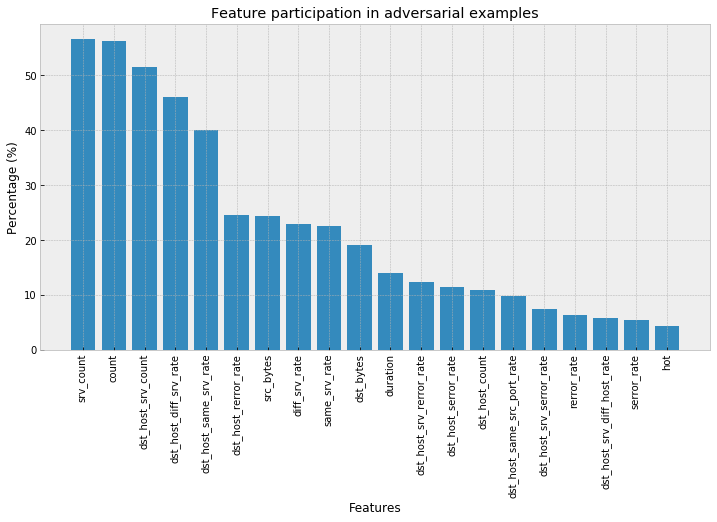

In [66]:
feats = dict()
total = 0
orig_attack = X_test_scaled - X_adv
for i in range(0, orig_attack.shape[0]):
	ind = np.where(orig_attack[i, :] != 0)[0]
	total += len(ind)
	for j in ind:
		if j in feats:
			feats[j] += 1
		else:
			feats[j] = 1

# The number of features that where changed for the adversarial samples
print("Number of unique features changed with JSMA: {}".format(len(feats.keys())))
print("Number of average features changed per datapoint with JSMA: {}".format(total/len(orig_attack)))

top_10 = sorted(feats, key=feats.get, reverse=True)[:10]
top_20 = sorted(feats, key=feats.get, reverse=True)[:20]
print("Top ten features: ", X_test.columns[top_10])

top_10_val = [100*feats[k] / y_test.shape[0] for k in top_10]
top_20_val = [100*feats[k] / y_test.shape[0] for k in top_20]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(20), top_20_val, align='center')
plt.xticks(np.arange(20), X_test.columns[top_20], rotation='vertical')
plt.title('Feature participation in adversarial examples')
plt.ylabel('Percentage (%)')
plt.xlabel('Features')
plt.savefig('Adv_features.png')
plt.show()